In [1]:
import pandas as pd
import numpy as np
import os
#import shutil
import matplotlib.pyplot as plt
#from sklearn.preprocessing import quantile_transform
import itertools
from scipy.stats import linregress
from scipy.stats import spearmanr
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# read in big bac csv file
big = pd.read_csv("~/combat_results/big_after_ComBat2.csv") 
# for big dataset, make rownames
#big = big.iloc[:, 1:]           # Step 1: remove the first column
big.index = big.iloc[:, 0]      # Step 2: set the new first column as index
big = big.iloc[:, 1:]           # Step 3: drop that column from the data
print(big.iloc[:6, :6])

                 PRJDB10485_DRR243823  PRJDB10485_DRR243824  \
Unnamed: 0                                                    
Acidaminococcus            -19.916319            -19.916319   
Actinomyces                -19.920788            -19.920788   
Acutalibacter              -19.904559              3.022243   
Adlercreutzia                8.967888              8.822689   
Agathobaculum              -19.899449              5.545255   
Akkermansia                -19.908716             10.513457   

                 PRJDB10485_DRR243825  PRJDB10485_DRR243826  \
Unnamed: 0                                                    
Acidaminococcus            -19.916319            -19.916319   
Actinomyces                -19.920788            -19.920788   
Acutalibacter              -19.904559            -19.904559   
Adlercreutzia              -19.908758            -19.908758   
Agathobaculum              -19.899449              1.023547   
Akkermansia                 10.849675            -19.9

In [3]:
# read in small bac file 
small = pd.read_csv("~/combat_results/small_after_ComBat2.csv") 
# for small dataset, make rownames
#small = small.iloc[:, 1:]           # Step 1: remove the first column
small.index = small.iloc[:, 0]      # Step 2: set the new first column as index
small = small.iloc[:, 1:]           # Step 3: drop that column from the data
print(small.iloc[:6, :6])

                 PD1SS17052dna201907dbDec22  PD117Pittsdna201907dbDec22  \
Unnamed: 0                                                                
Acidaminococcus                  -27.905575                  -12.215861   
Actinomyces                      -25.442331                  -11.086597   
Acutalibacter                     -7.687554                   -5.058617   
Adlercreutzia                    -14.089484                  -11.075905   
Agathobaculum                     -5.720465                    1.030011   
Akkermansia                       -0.835710                  -11.503600   

                 PD1SS17005dna201907dbDec22  PD1TPF1820dna201907dbDec22  \
Unnamed: 0                                                                
Acidaminococcus                  -13.776716                   -7.002818   
Actinomyces                      -25.442331                   -8.562088   
Acutalibacter                     -0.925561                   -6.607248   
Adlercreutzia           

In [4]:
# Log2 transform with a small offset
big_log = big.T     # Transpose to have samples as rows
small_log = small.T
big_samples = big_log.index.tolist()
small_samples = small_log.index.tolist()
# Standardize
scaler = StandardScaler()
big_scaled = scaler.fit_transform(big_log)
#small_scaled = scaler.fit_transform(small_log)
small_scaled = scaler.transform(small_log)

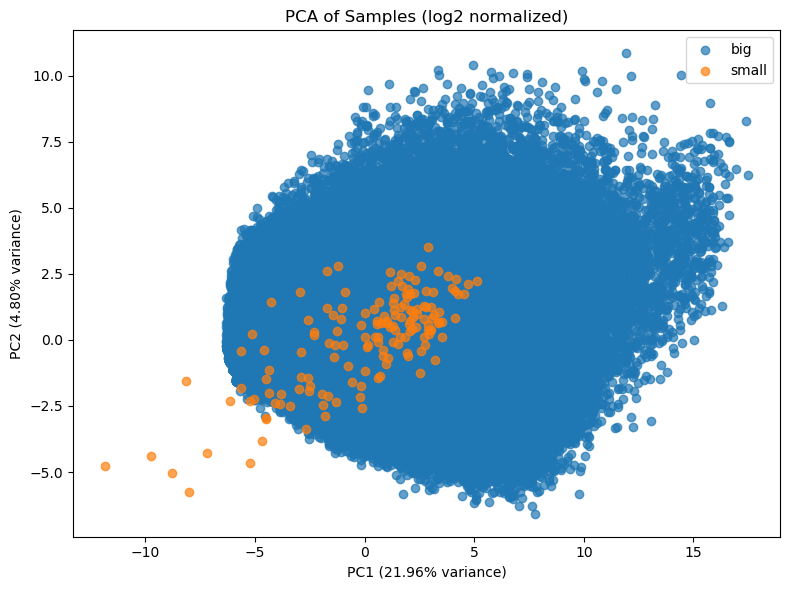

In [5]:
# Fit PCA on 'big', apply to both
pca = PCA(n_components=2)
pca.fit(big_scaled)
pca_big = pca.transform(big_scaled)
pca_small = pca.transform(small_scaled)

# Variance explained
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# Plot
plt.figure(figsize=(8,6))
plt.scatter(pca_big[:, 0], pca_big[:, 1], label='big', alpha=0.7)
plt.scatter(pca_small[:, 0], pca_small[:, 1], label='small', alpha=0.7)
plt.xlabel(f'PC1 ({pc1_var:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.2f}% variance)')
plt.title('PCA of Samples (log2 normalized)')
plt.legend()
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/S.Fig4G_PCA_orig.pdf", format="pdf")
plt.show()


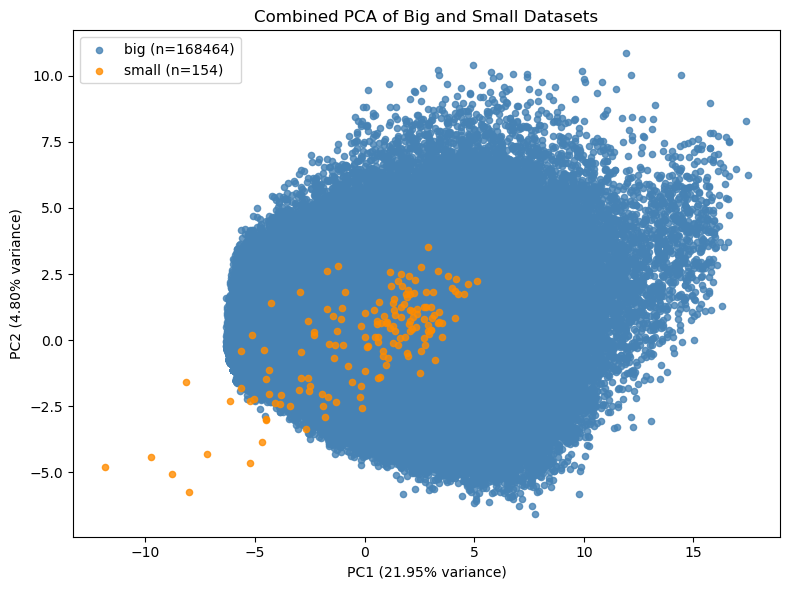

In [8]:
# 🧩 Combine scaled data before PCA
combined_scaled = np.vstack([big_scaled, small_scaled])
combined_labels = ['big'] * len(big_scaled) + ['small'] * len(small_scaled)

# ⚙️ Run PCA on combined data
pca = PCA(n_components=2)
pca_embedded = pca.fit_transform(combined_scaled)

# 📊 Variance explained
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# 📄 Make DataFrame for plotting
df_pca = pd.DataFrame(pca_embedded, columns=['PC1', 'PC2'])
df_pca['group'] = combined_labels

# 🎨 Plot with transparency and small dots for big data
plt.figure(figsize=(8,6))

# Plot big group first (so small is on top)
df_big = df_pca[df_pca['group'] == 'big']
df_small = df_pca[df_pca['group'] == 'small']

plt.scatter(df_big['PC1'], df_big['PC2'], 
            label=f'big (n={len(df_big)})', 
            alpha=0.8, s=20, color='steelblue')

plt.scatter(df_small['PC1'], df_small['PC2'], 
            label=f'small (n={len(df_small)})', 
            alpha=0.8, s=20, color='darkorange')

plt.xlabel(f'PC1 ({pc1_var:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.2f}% variance)')
plt.title('Combined PCA of Big and Small Datasets')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
print(f"Number of samples in big: {len(pca_big)}")
print(f"Number of samples in small: {len(pca_small)}")
print(f"Total samples: {len(pca_big) + len(pca_small)}")


Number of samples in big: 168464
Number of samples in small: 154
Total samples: 168618


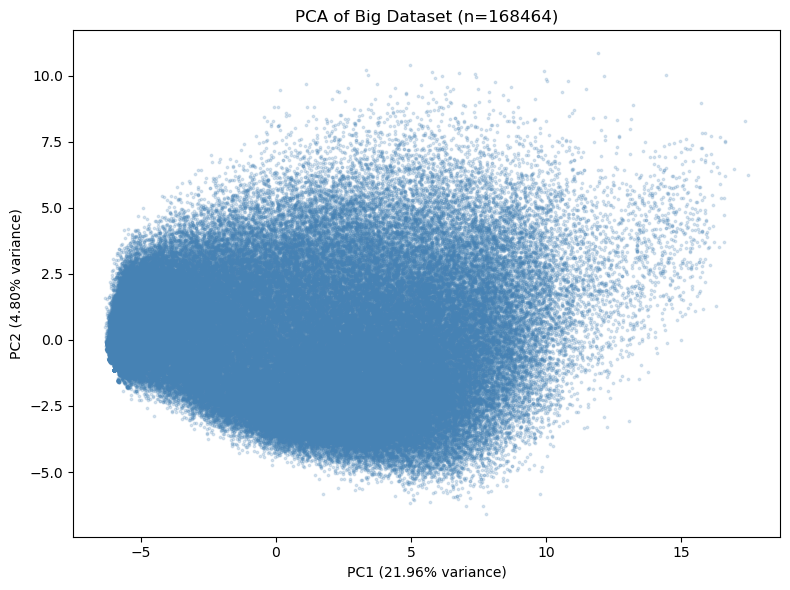

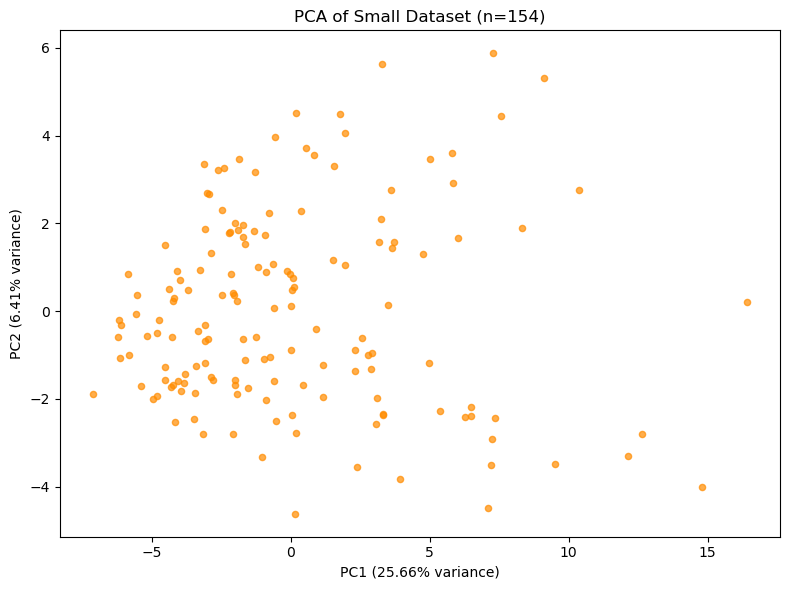

In [9]:
# --- PCA on big data only ---
pca_big_only = PCA(n_components=2)
pca_big_embedded = pca_big_only.fit_transform(big_scaled)

pc1_var_big = pca_big_only.explained_variance_ratio_[0] * 100
pc2_var_big = pca_big_only.explained_variance_ratio_[1] * 100

plt.figure(figsize=(8,6))
plt.scatter(pca_big_embedded[:,0], pca_big_embedded[:,1], s=3, alpha=0.2, color='steelblue')
plt.xlabel(f'PC1 ({pc1_var_big:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var_big:.2f}% variance)')
plt.title(f'PCA of Big Dataset (n={len(big_scaled)})')
plt.tight_layout()
plt.show()

# --- PCA on small data only ---
pca_small_only = PCA(n_components=2)
pca_small_embedded = pca_small_only.fit_transform(small_scaled)

pc1_var_small = pca_small_only.explained_variance_ratio_[0] * 100
pc2_var_small = pca_small_only.explained_variance_ratio_[1] * 100

plt.figure(figsize=(8,6))
plt.scatter(pca_small_embedded[:,0], pca_small_embedded[:,1], s=20, alpha=0.7, color='darkorange')
plt.xlabel(f'PC1 ({pc1_var_small:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var_small:.2f}% variance)')
plt.title(f'PCA of Small Dataset (n={len(small_scaled)})')
plt.tight_layout()
plt.show()


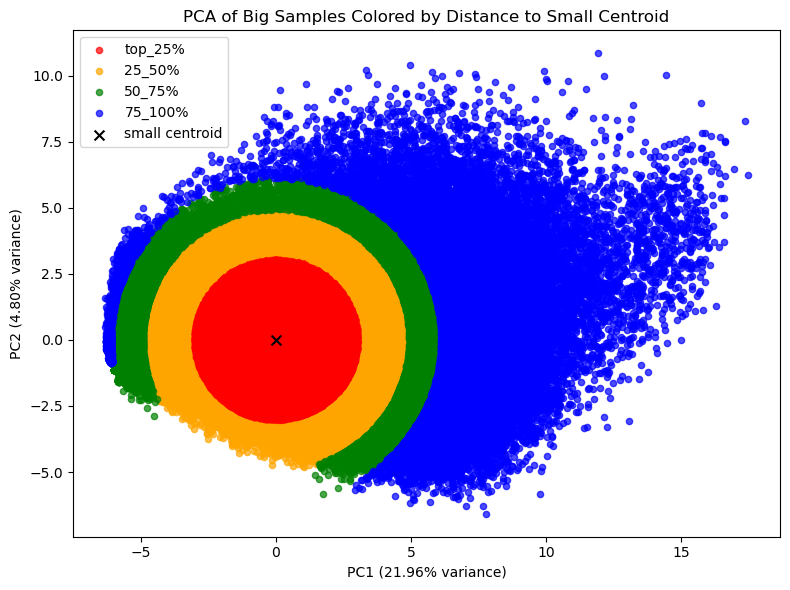

In [6]:
# 1️⃣ Compute centroid of small samples
small_center_pca = pca_small.mean(axis=0) # small PCA coords

# 2️⃣ Distances from each big sample to centroid
distances_pca = np.linalg.norm(pca_big - small_center_pca, axis=1)

# 3️⃣ Assign quartile groups
quantiles_pca = np.quantile(distances_pca, [0.25, 0.5, 0.75])

groups_pca = []
for d in distances_pca:
    if d <= quantiles_pca[0]:
        groups_pca.append('top_25%')
    elif d <= quantiles_pca[1]:
        groups_pca.append('25_50%')
    elif d <= quantiles_pca[2]:
        groups_pca.append('50_75%')
    else:
        groups_pca.append('75_100%')

# 4️⃣ Plot only big samples colored by distance
df_pca_big = pd.DataFrame(pca_big, columns=['PC1','PC2'], index=big_samples)
df_pca_big['group'] = groups_pca

plt.figure(figsize=(8,6))
colors = {'top_25%':'red','25_50%':'orange','50_75%':'green','75_100%':'blue'}
for grp, color in colors.items():
    subset = df_pca_big[df_pca_big['group']==grp]
    plt.scatter(subset['PC1'], subset['PC2'], label=grp, alpha=0.7, s=20, color=color)

# small centroid
plt.scatter(small_center_pca[0], small_center_pca[1], c='black', marker='x', s=50, label='small centroid')

plt.xlabel(f'PC1 ({pc1_var:.2f}% variance)')
plt.ylabel(f'PC2 ({pc2_var:.2f}% variance)')
plt.title('PCA of Big Samples Colored by Distance to Small Centroid')
plt.legend()
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/S.Fig4H_PCA_distance.pdf", format="pdf")
plt.show()

In [11]:
# Return 4 dataframes with selected samples
dfs_by_group = {}
for grp in ['top_25%','25_50%','50_75%','75_100%']:
    selected_samples = df_pca_big[df_pca_big['group']==grp].index
    dfs_by_group[grp] = big[selected_samples].T  # bacteria matrix

In [14]:
output_dir = "/ix/hpark/Jie/LMM/PCA_dist_combat2/"  # change to your desired folder
os.makedirs(output_dir, exist_ok=True)

for grp, df in dfs_by_group.items():
    filename = os.path.join(output_dir, f"big_samples_{grp}.csv")
    df.to_csv(filename)
    print(f"Saved {grp} to {filename}")

Saved top_25% to /ix/hpark/Jie/LMM/PCA_dist_combat2/big_samples_top_25%.csv
Saved 25_50% to /ix/hpark/Jie/LMM/PCA_dist_combat2/big_samples_25_50%.csv
Saved 50_75% to /ix/hpark/Jie/LMM/PCA_dist_combat2/big_samples_50_75%.csv
Saved 75_100% to /ix/hpark/Jie/LMM/PCA_dist_combat2/big_samples_75_100%.csv


In [12]:
print(dfs_by_group["top_25%"].shape)
print(dfs_by_group["25_50%"].shape)
print(dfs_by_group["50_75%"].shape)
print(dfs_by_group["75_100%"].shape)

(42116, 104)
(42116, 104)
(56390, 104)
(27842, 104)
